# HitAnno demo

## Import libraries

In [1]:
from hitanno.data_processing import *
from hitanno.visualization import *
from hitanno.trainer import *
from hitanno.model import *

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import warnings
import torch
import os


warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

SEED = 42
setup_seed(SEED)

/home/wangzian/anaconda3/envs/hitanno/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
OUTPUT_DIREC = "./outputs/"
os.makedirs(OUTPUT_DIREC + "predictions/", exist_ok=True)
os.makedirs(OUTPUT_DIREC + "model/", exist_ok=True)
os.makedirs(OUTPUT_DIREC + "metrics/", exist_ok=True)
os.makedirs(OUTPUT_DIREC + "figures/", exist_ok=True)

## Preprocess data

Download Domcke_2020_adrenal_mini dataset used in the tutorial and place the file in the `data/` directory before running the notebook.

In [3]:
print("#" * 80)
print("loading train dataset ...")
adata_train = sc.read_h5ad("./data/Domcke2020_adrenal_mini_train.h5ad")
print(adata_train)
print(type(adata_train.X))
display(adata_train.var.head())
display(adata_train.obs.head())

################################################################################
loading train dataset ...
AnnData object with n_obs × n_vars = 24000 × 1050819
    obs: 'label'
<class 'scipy.sparse._csc.csc_matrix'>


""
chr1:9992-10688
chr1:14831-15063
chr1:17351-17617
chr1:29200-29505
chr1:115525-115871


,label
CAATTATAGTTGGTATCAGATTCTGGCGCAGTACGATTCT,Adrenocortical cells
GTTCTCCGGAATATCTTCCGTATGCTTACTTGGATCAGGC,Adrenocortical cells
TTAGGCGTCCACGAGGAGCCGTATCAATATCCAGCTCGCC,Adrenocortical cells
GAGAGTTAACTTGGAACTGGTATGCTTACTTGGATCAGGC,Chromaffin cells
ATAAGTCGAAGCATTAGGCGGTTCGTCTGATGATTCTCGT,Adrenocortical cells


In [4]:
print("loading test dataset ...")
adata_test = sc.read_h5ad("./data/Domcke2020_adrenal_mini_test.h5ad")
print(adata_test)
print(type(adata_test.X))
display(adata_test.var.head())
display(adata_test.obs.head())

loading test dataset ...
AnnData object with n_obs × n_vars = 6000 × 1050819
    obs: 'label'
<class 'scipy.sparse._csc.csc_matrix'>


""
chr1:9992-10688
chr1:14831-15063
chr1:17351-17617
chr1:29200-29505
chr1:115525-115871


,label
GTTATCGGTAGGCTGGCTCTTGCGTCTATAGGCATGGCCA,Adrenocortical cells
GGAGAGATCCGCCTCGGTAAAAGATGGATTGAGGAGCCAG,Adrenocortical cells
TCAGAACGACTGCGAATCGGATGAATACCAGGAGTCGTCT,Myeloid cells
GGCCGTTGATTACGCAGGTTGATCCATAACCATCTTCAGA,Adrenocortical cells
TAGGCTTCGAGGTTAGTTGGAAGATGGATTTGGATCAGGC,Adrenocortical cells


In [5]:
BATCH_SIZE = 4
class_list = adata_train.obs['label'].cat.categories.to_list()

In [6]:
print("#" * 80)
print("processing data ...")
train_loader, test_loader, eval_loader, \
    peak_num, col_list, peak_num_list = hitanno_preprocess_data(
        adata_train,
        adata_test,
        batch_size=BATCH_SIZE,
        peak_num_ct=0, # let hitanno to calculate the peak_num_ct for the dataset
        seed=SEED,
    )

################################################################################
processing data ...
2000 peaks per cell type, 18000 peaks in total


## Build the HitAnno model

In [7]:
HitAnno_model = HitAnno(
    batch_size=BATCH_SIZE,
    peak_num_list=peak_num_list,
    peak_num_all=peak_num,
    output_size=len(class_list),
    device=device,
).to(device)

## Train on the train dataset

In [8]:
print("#" * 80)
print("training model ...")
hitanno_train(train_loader, 
              eval_loader, 
              HitAnno_model, 
              col_list, 
              device, 
              save_model_path=OUTPUT_DIREC + "model/" + f"hitanno_model.pth")

################################################################################
training model ...
Epoch 01/20, loss: 1.012; loss on eval set: 0.470, accuracy on eval set: 0.856;
Epoch 02/20, loss: 0.303; loss on eval set: 0.184, accuracy on eval set: 0.945;
Epoch 03/20, loss: 0.166; loss on eval set: 0.168, accuracy on eval set: 0.948;
Epoch 04/20, loss: 0.124; loss on eval set: 0.122, accuracy on eval set: 0.961;
Epoch 05/20, loss: 0.096; loss on eval set: 0.099, accuracy on eval set: 0.970;
Epoch 06/20, loss: 0.064; loss on eval set: 0.102, accuracy on eval set: 0.974;
Epoch 07/20, loss: 0.051; loss on eval set: 0.077, accuracy on eval set: 0.979;
Epoch 08/20, loss: 0.041; loss on eval set: 0.086, accuracy on eval set: 0.978;
Epoch 09/20, loss: 0.037; loss on eval set: 0.084, accuracy on eval set: 0.981;
Epoch 10/20, loss: 0.033; loss on eval set: 0.073, accuracy on eval set: 0.981;
Epoch 11/20, loss: 0.027; loss on eval set: 0.083, accuracy on eval set: 0.979;
Epoch 12/20, loss: 0

## Predict on the test dataset

In [9]:
print("#" * 80)
print("evaluating model ...")
y_label, y_pred, \
    trans_output = hitanno_predict(
        test_loader, 
        HitAnno_model, 
        device, 
        class_list, 
        save_label_path=OUTPUT_DIREC + "predictions/" + f'hitAnno_predict_labels.csv')

################################################################################
evaluating model ...


In [10]:
pd.set_option('display.width', 300)
calculate_metrices(y_label, 
                   y_pred, 
                   index=pd.CategoricalIndex(class_list),
                   save_metirces_path=OUTPUT_DIREC + "metrics/" + "performance.json")

                            Adrenocortical cells  Chromaffin cells  Erythroblasts  Megakaryocytes  Myeloid cells  Schwann cells  Stromal cells  Sympathoblasts  Vascular endothelial cells
Adrenocortical cells                        4790                 0              0               0              0              0             14               0                           0
Chromaffin cells                               0               301              0               0              1              1              0               1                           0
Erythroblasts                                  0                 0             58               0              2              0              0               0                           0
Megakaryocytes                                 3                 0              0               6              1              0              3               0                           0
Myeloid cells                                  1                 

## Visualize the result

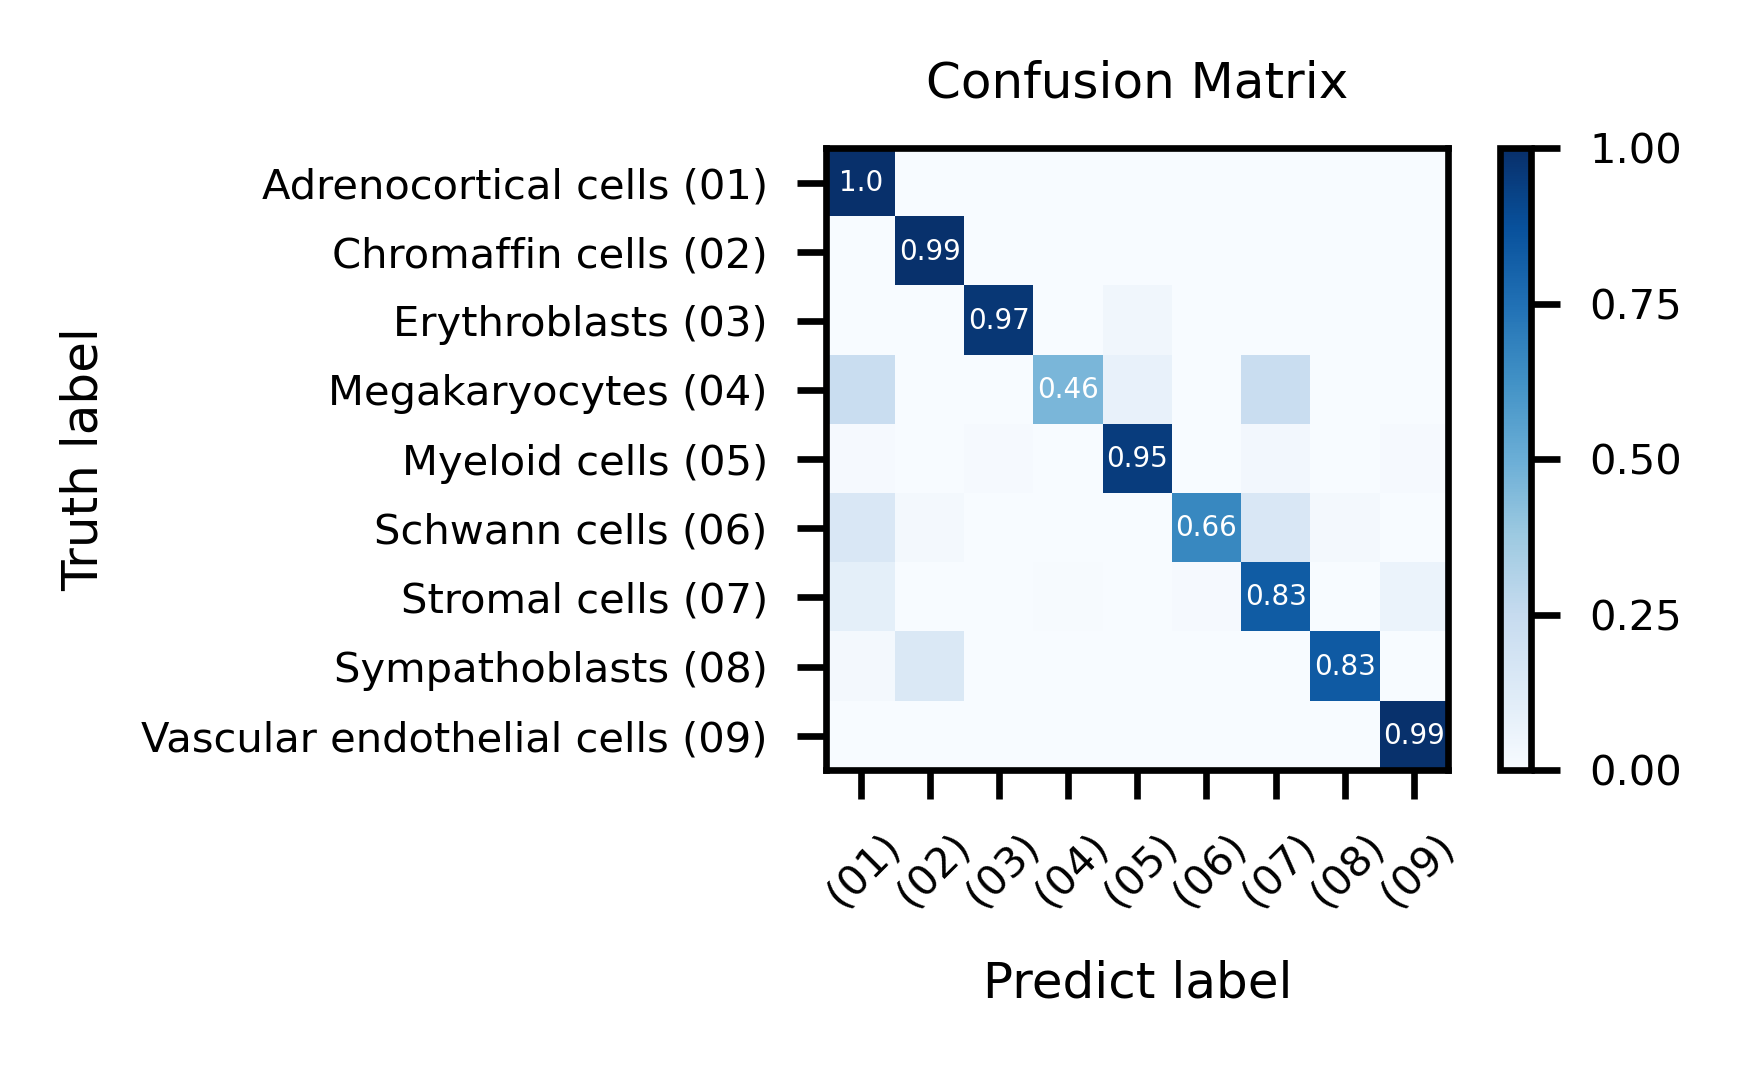

In [11]:
draw_confusion_matrix(label_true=y_label,
                      label_pred=y_pred,
                      label_name=pd.CategoricalIndex(class_list),
                      title=f"Confusion Matrix",
                      save_path=OUTPUT_DIREC + "figures/" + "confusion_matrix.png",
                      dpi=1200)

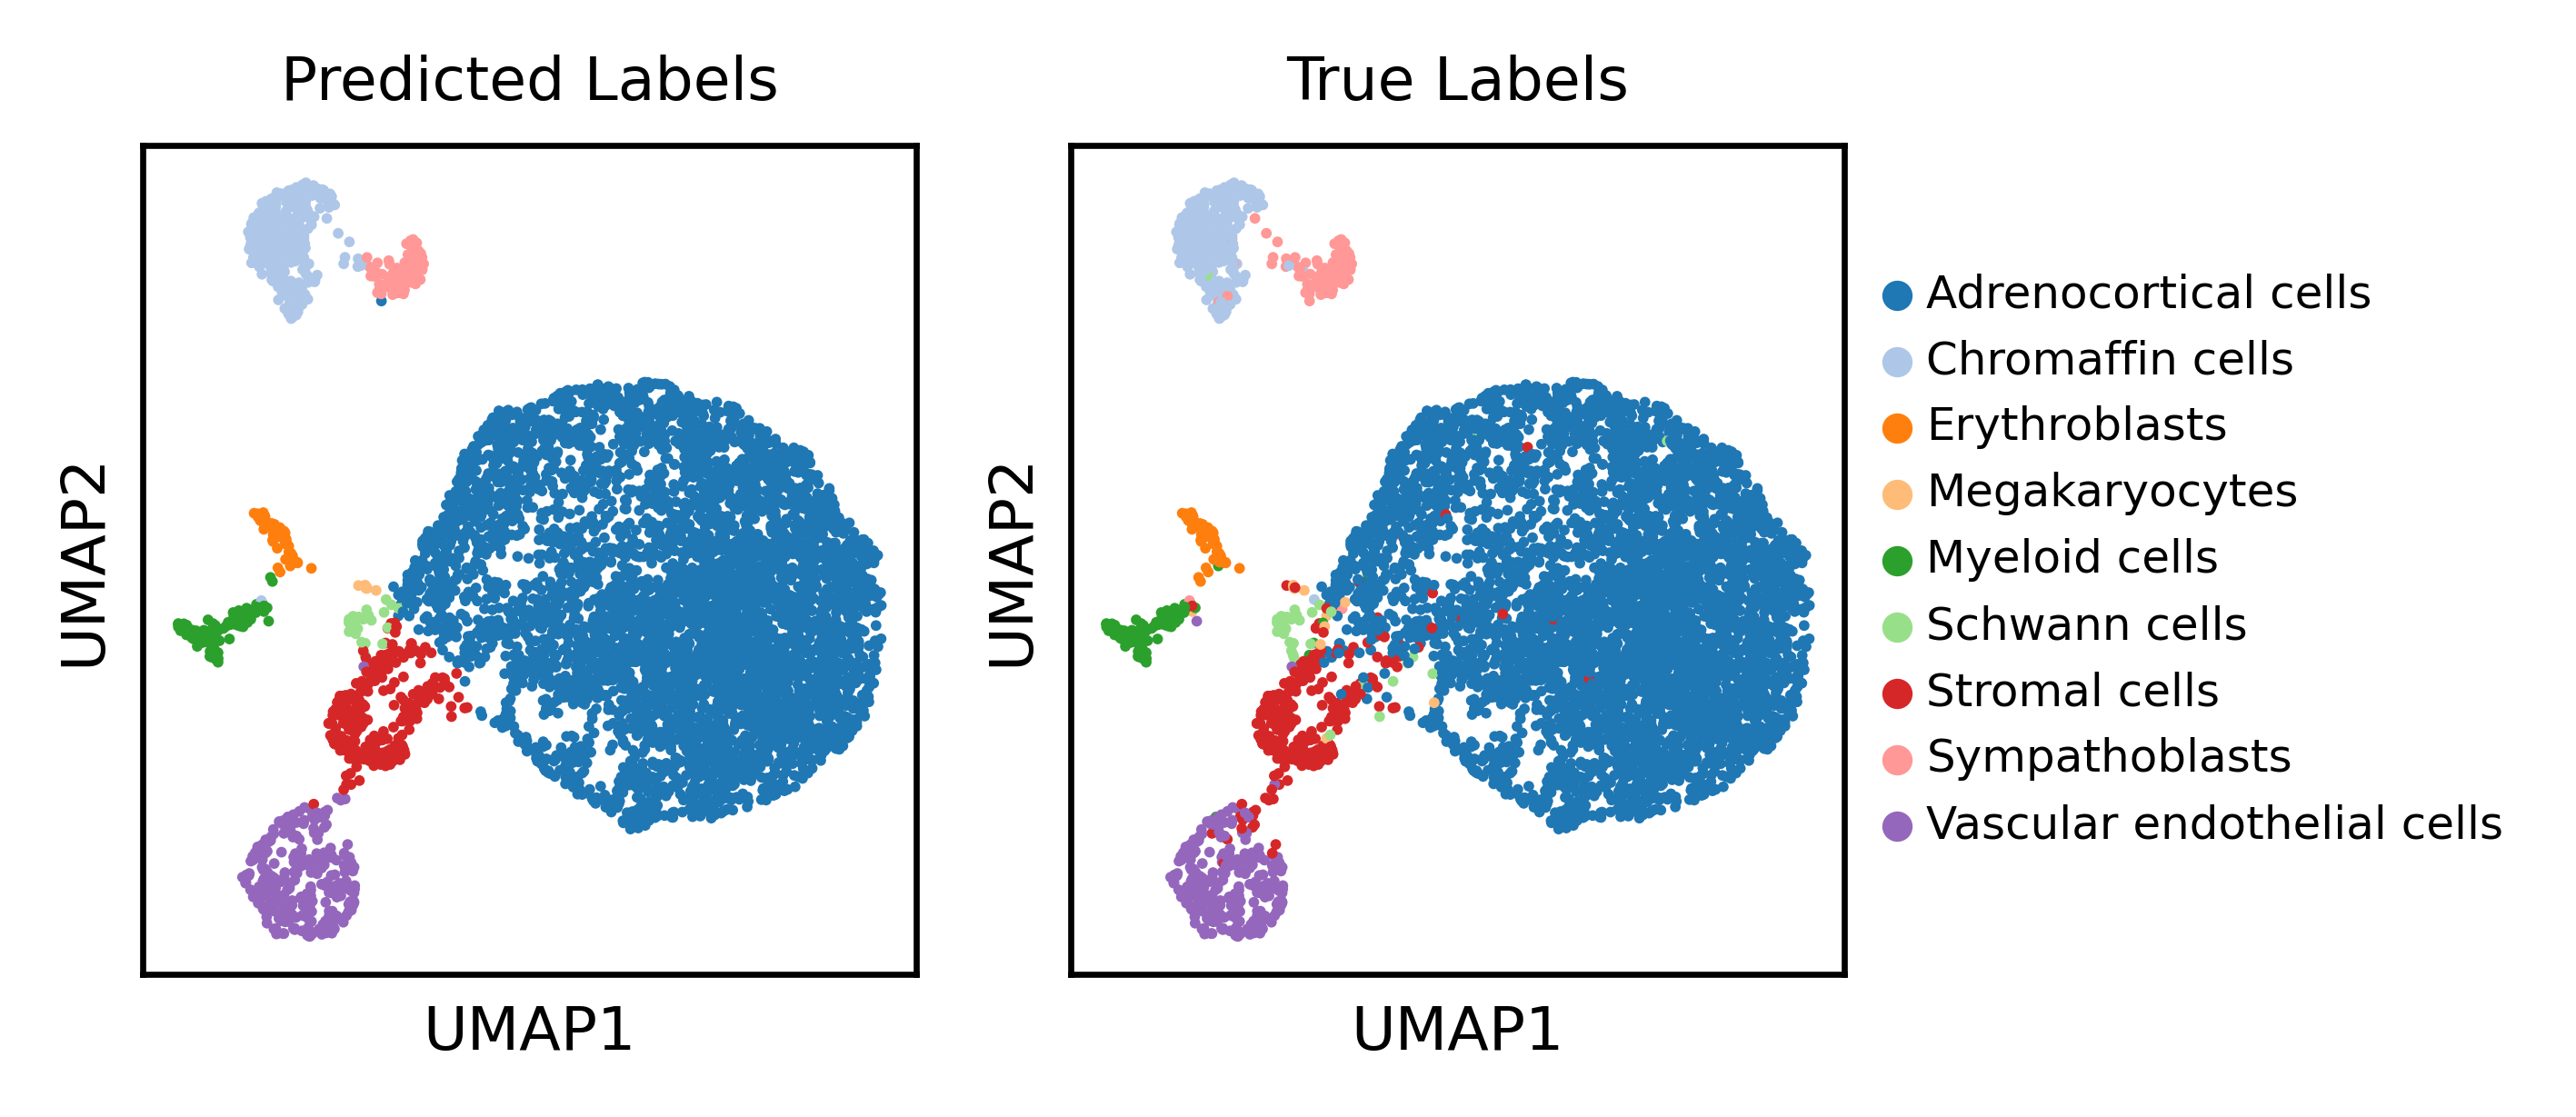

In [12]:
cmap_cell = {class_list[i]: plt.cm.tab20(i) for i in range(len(class_list))}
plot_and_save_umap(
    trans_output=trans_output,
    Predicted_labels=[class_list[i] for i in y_pred],
    True_labels=[class_list[i] for i in y_label],
    label_title="True Labels",
    pred_title="Predicted Labels",
    label_palette=cmap_cell,
    pred_palette=cmap_cell,
    save_label_path=OUTPUT_DIREC + "figures/" + "umap.png",
)